# Robust training with MOM on PyTorch

In [46]:
import torch
import itertools
import torch.utils.data
import numpy as np
import numpy.random as alea
from torch.utils.data import Sampler
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import os
from sklearn.preprocessing import normalize
from torchvision import transforms
import torch.nn.functional as act
from torch.utils import data
import torchvision.models as models
from random import *
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
plt.style.use('seaborn-darkgrid')
%matplotlib notebook

In [2]:
random_seed = 7
alea.seed(random_seed)

###  Creation of a MOM sampler

In [3]:
class MOM_sampler(Sampler) : 
    
    "return a generator with the median block"
    
    def __init__(self , model , dataset , K , loss = torch.nn.MSELoss(reduction='elementwise_mean') 
               , random_state = True) : 
        
        "To compute the median block, we need X, Y, K and the loss"
        
        print("model : " , model , "dataset : " , dataset ,"K : " , K , "loss :" , loss , "epochs : " ,"random_state : " , random_state)
        self.model = model
        self.dataset = dataset
        self.n_samples , self.input_shape = len(self.dataset) , np.shape(self.dataset[0][0])
        self.K = K
        self.batch_size = self.n_samples // K
        self.loss = loss
        self.random_state = random_state
        
    
    def __iter__(self) : 
            
        if self.random_state : 
        
            idx = alea.permutation(self.n_samples)
            
        else :
            
            idx = np.arange(self.n_samples)

        if self.K == 1 : 
            return iter(idx)
        
        blocks = [idx[i * (self.batch_size) : (i + 1) * self.batch_size] for i in range(self.K)]
        means_blocks = []
        
        for j in range(self.K):

            X_batch = torch.stack([self.dataset[idx][0].float() for idx in blocks[j]])
            Y_batch = torch.stack([self.dataset[idx][1].float() for idx in blocks[j]])
            
            mean = self.loss(self.model(X_batch.float()),Y_batch.float()).item()
            means_blocks.append(mean)
            
        indices = np.argsort(means_blocks)[int(np.ceil( len(means_blocks) / 2 ))]
        return iter(blocks[indices])
        
    def __len__(self) : 
        
        return 1

In [4]:
class Dataset(data.Dataset):
    
    def __init__(self, X,  Y , transform = None):
        
        self.X = X
        self.Y = Y
        self.transform = transform
        
    def __len__(self):
        return len(self.Y)

    def __getitem__(self, index):
    
        # Load data and get label
        if self.transform : 
            
            X = self.transform(self.X[index])
                               
        else : 
            
            X = self.X[index]
            
        y = self.Y[index]

        return X, y

In [6]:
def accuracy(model, data_x, data_y):
    
    X = torch.Tensor(data_x)
    Y = torch.LongTensor(data_y)
    
    oupt = (model(X).detach().numpy().flatten() > 0.5) * 1
    Y_real = np.array(Y)
    
    false_ = np.sum(np.abs(oupt - Y_real))/len(Y_real)
    
    return 1-false_

In [47]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

### Application to crocodiles and pinguins recognition

We want to classify crocodiles and pionguins with convolutional nets. We use a convolutional network to classify those animals. In order to check if our training is robust to outliers, we corrupt our dataset with fish photos.

In [11]:
images = []
target = []
min_n , min_p = 1000 , 1000
i = 0

for animal in ["crocodile" , "pinguin"] : 
    
    file = os.listdir("data/tiny-imagenet-200/train/" + animal + "/images")
    
    for f in file : 
        
        img = Image.open("data/tiny-imagenet-200/train/" + animal + "/images/" + f)
        n,p = img.size
        height = min(n,p)
        box = ( 0 , 0 , height , height)
        img = img.crop(box)  # On rend l'image carré en la rognant
        #img = img.resize(( 224 , 224 ))   # On standardise la taille de l'image 
        if len(np.array(img).shape) == 3 : 
            
            images.append(np.array(img)/255)
            target.append(i)
            
    i += 1

outliers = []

file = os.listdir("data/tiny-imagenet-200/train/fish/images")
    
for f in file : 
        
    img = Image.open("data/tiny-imagenet-200/train/fish/images/" + f)
    n,p = img.size
    height = min(n,p)
    box = ( 0 , 0 , height , height)
    img = img.crop(box)
    if len(np.array(img).shape) == 3 : 
            
        outliers.append(np.array(img)/255)
        
images_train , images_test , target_train , target_test = train_test_split(images , target , random_state = random_seed)

We compute the mean and std of our images per channel to normalize them, normalization is very important in convolutional network to avoid vanishing gradient and to keep it low.

In [12]:
mean = [0 , 0 , 0]
mean_squared = [0 , 0 , 0]

for i in images : 
    
    mean[0] += np.mean(i[0,:,:])/1500
    mean[1] += np.mean(i[1,:,:])/1500
    mean[2] += np.mean(i[2,:,:])/1500

In [13]:
transformer = transforms.Compose( [ transforms.ToTensor() ])#, transforms.Normalize(mean = mean, std = [1,1,1])])

Our network will be a convolutional network with 3 convolutional layers, max pooling layers after every convolutionnal one and a final dense layer..

In [14]:
class CNN(torch.nn.Module):
    
    #Our batch shape for input x is (3 , 64 , 64)
    
    def __init__(self):
        super(CNN, self).__init__()
        
        #Input channels = 3, output channels = 16
        self.conv1 = torch.nn.Conv2d(3 , 16 , 3 , stride = 1 , padding = 0)
        self.pool1 = torch.nn.MaxPool2d(2)
        
        #Input channels = 16, output channels = 32
        self.conv2 = torch.nn.Conv2d(16, 32, 3, stride=1, padding = 0)
        self.pool2 = torch.nn.MaxPool2d(2)
        
        #Input channels = 32, output channels = 64
        self.conv3 = torch.nn.Conv2d(32, 64, 3, stride=1, padding = 0)
        self.pool3 = torch.nn.MaxPool2d(2)
        
        
        #128 input features, 1 output features for binary classification
        self.fc1 = torch.nn.Linear(2304, 1)
        
    def forward(self, x):
        
        #Computes the activation of the first convolution
        #Size changes from (3, 64, 64) to (16, 64, 64)
        #print(x.shape)
        x = act.relu(self.conv1(x))
        
        #print(x.shape)
        #Size changes from (16, 64, 64) to (16, 32, 32)
        x = self.pool1(x)
        
        #print(x.shape)
        #Computes the activation of the second convolution
        #Size changes from (16, 32, 32) to (32, 32 , 32)
        x = act.relu(self.conv2(x))
        
        #print(x.shape)
        #Size changes from (32, 32 , 32) to (32, 16, 16)
        x = self.pool2(x)
        
        #print(x.shape)
        #Computes the activation of the third convolution
        #Size changes from (32 , 16 , 16) to (64, 16, 16)
        x = act.relu(self.conv3(x))
        
        #print(x.shape)
        #Size changes from (64, 16, 16) to (64, 6, 6)
        x = self.pool3(x)
        
        #print(x.shape)
        #Reshape data to input to the input layer of the neural net
        #Size changes from (128 , 1 , 1) to (1, 128)
        #Recall that the -1 infers this dimension from the other given dimension
        x = x.view(-1, 64 * 36)
        
        #print(x.shape)
        #Computes the activation of the fully connected layer
        #Size changes from (1, 2304) to (1, 1)
        x = act.sigmoid(self.fc1(x))
        
        return(x)

In [15]:
n_outliers = 4
K = 6

In [16]:
for i in range(n_outliers):
    
    images_train.append(outliers[i])
    target_train.append(randint(0,1))

target_train = torch.FloatTensor(target_train)

In [17]:
target_test = torch.FloatTensor(target_test)

In [49]:
CNN_ = CNN()
data_train = Dataset(images_train , target_train , transform = transformer)
data_test = Dataset(images_test , target_test , transform = transformer)
sampler = MOM_sampler(CNN_ , data_train , K , loss = torch.nn.BCELoss(weight=None, size_average=None,
                                                          reduce=None, reduction='sum') , random_state = random_seed)
optimizer = torch.optim.Adam( CNN_.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08,
                                          weight_decay=0, amsgrad=False)
loss = torch.nn.BCELoss(weight=None, size_average=None, reduce=None, reduction='sum')

model :  CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2304, out_features=1, bias=True)
) dataset :  <__main__.Dataset object at 0x121495470> K :  6 loss : BCELoss() epochs :  random_state :  7


In [19]:
train_data_x = torch.stack([data_train[i][0] for i in range(len(data_train))]).float()
train_data_y = torch.stack([data_train[i][1] for i in range(len(data_train))]).long()
val_data_x = torch.stack([data_test[i][0] for i in range(len(data_test))]).float()
val_data_y = torch.stack([data_test[i][1] for i in range(len(data_test))]).long()

In [21]:
history = {'loss' : [] , 'val_loss' : [] , 'acc' : [] , 'val_acc' :  []}
n_iter = 100

for epoch in range(n_iter):
            
    DataLoader = torch.utils.data.DataLoader( data_train, batch_size = min((len(data_train)//K),32) ,
                                                          num_workers=2 ,
                                                          sampler = sampler)
    running_loss = 0.0
    running_val_loss = 0.0
        
    for i, data in enumerate(DataLoader, 0):
        # get the input 
        
        inputs, labels = data
        inputs = inputs.float()
        labels = labels.float()

        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = CNN_(inputs)
        loss_ = loss(outputs, labels)  # calcul de la loss
        val_loss_ = loss(CNN_(val_data_x), val_data_y.float())
        
        loss_.backward() #compute the gradient of the loss
        optimizer.step()

        # print statistics
        running_loss += loss_.item()
        running_val_loss += val_loss_.item()
    
    acc = accuracy(CNN_ , train_data_x , train_data_y)
    val_acc = accuracy(CNN_ , val_data_x , val_data_y)
    print("Epochs n°" + str(epoch) +": loss =", running_loss , "val_loss = ", running_val_loss,"accuracy = "
          , acc ,", val_accuracy = " , val_acc)
    
    history['loss'].append(running_loss)
    history['val_loss'].append(running_val_loss)
    history['acc'].append(acc)
    history['val_acc'].append(val_acc)
    
print('Finished Training')
torch.save(CNN_.state_dict(), "models/CNN_1")

/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([125])) that is different to the input size (torch.Size([125, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([249])) that is different to the 

Epochs n°0: loss = 76.33232021331787 val_loss =  590.6263275146484 accuracy =  0.7616511318242344 , val_accuracy =  0.7309236947791165
Epochs n°1: loss = 72.81484794616699 val_loss =  619.7120208740234 accuracy =  0.7097203728362184 , val_accuracy =  0.6706827309236948
Epochs n°2: loss = 73.64309883117676 val_loss =  567.0914001464844 accuracy =  0.7616511318242344 , val_accuracy =  0.7309236947791165
Epochs n°3: loss = 65.84744071960449 val_loss =  588.6461639404297 accuracy =  0.6378162450066578 , val_accuracy =  0.5461847389558233
Epochs n°4: loss = 65.87607288360596 val_loss =  610.4927368164062 accuracy =  0.7403462050599201 , val_accuracy =  0.7630522088353413
Epochs n°5: loss = 67.71302509307861 val_loss =  535.2253723144531 accuracy =  0.7909454061251664 , val_accuracy =  0.7550200803212852
Epochs n°6: loss = 64.80094814300537 val_loss =  598.5581207275391 accuracy =  0.6697736351531292 , val_accuracy =  0.5943775100401607
Epochs n°7: loss = 62.93298530578613 val_loss =  570.60

Epochs n°61: loss = 25.30721479654312 val_loss =  276.470760345459 accuracy =  0.9374167776298269 , val_accuracy =  0.9076305220883534
Epochs n°62: loss = 22.80154275894165 val_loss =  230.62438583374023 accuracy =  0.9347536617842876 , val_accuracy =  0.8995983935742972
Epochs n°63: loss = 20.89591658115387 val_loss =  233.9873275756836 accuracy =  0.9214380825565912 , val_accuracy =  0.8835341365461847
Epochs n°64: loss = 25.618135929107666 val_loss =  282.6125793457031 accuracy =  0.9254327563249001 , val_accuracy =  0.8995983935742972
Epochs n°65: loss = 33.25879430770874 val_loss =  238.50077438354492 accuracy =  0.933422103861518 , val_accuracy =  0.9156626506024097
Epochs n°66: loss = 26.783902168273926 val_loss =  244.2141342163086 accuracy =  0.9214380825565912 , val_accuracy =  0.8795180722891567
Epochs n°67: loss = 28.085115432739258 val_loss =  250.0682487487793 accuracy =  0.933422103861518 , val_accuracy =  0.9036144578313253
Epochs n°68: loss = 24.776748418807983 val_los

<IPython.core.display.Javascript object>


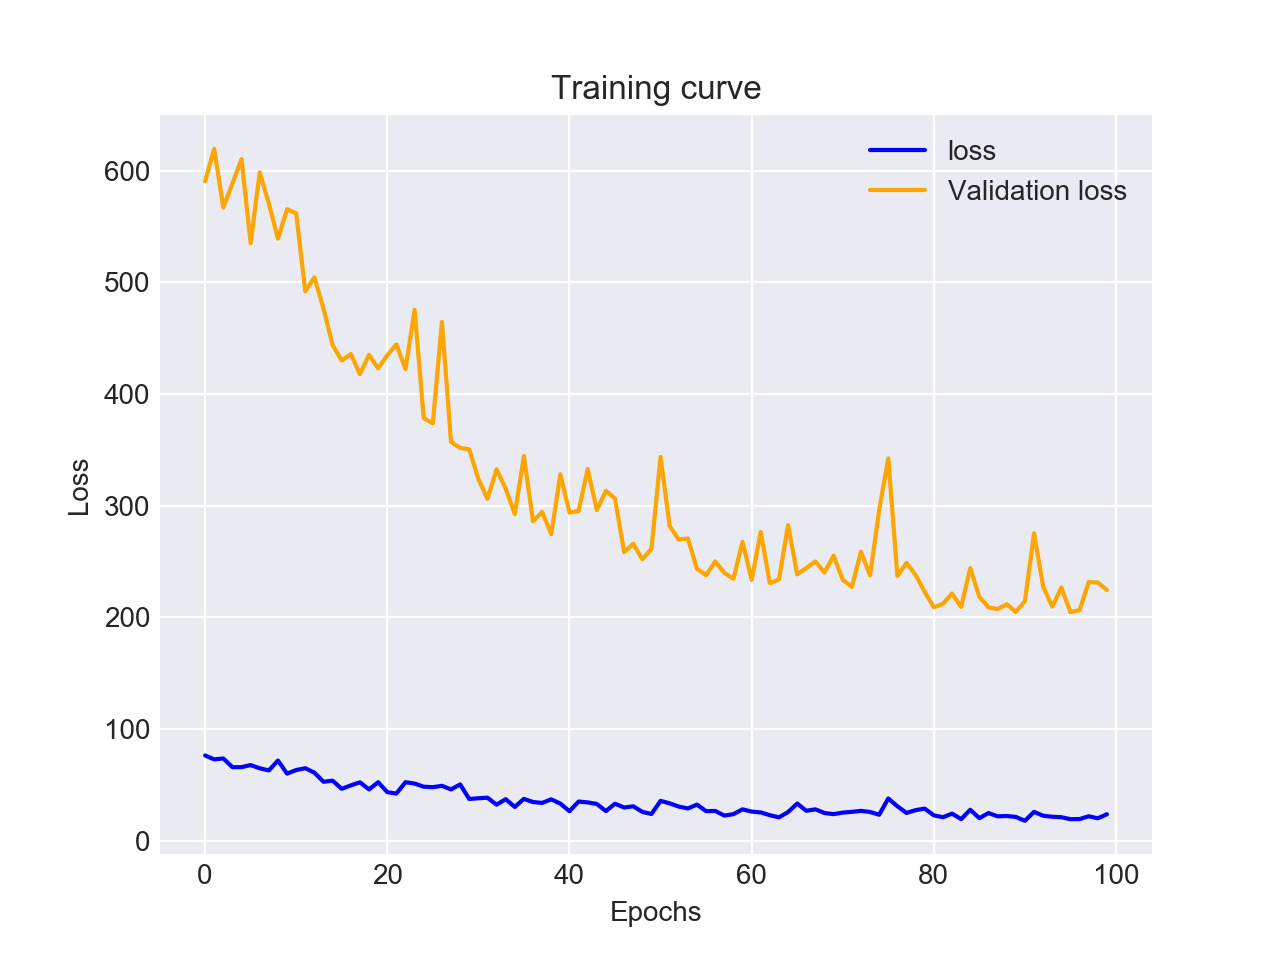

Text(0.5, 1.0, 'Training curve')

In [28]:
%matplotlib notebook
plt.plot(history['loss'] , color = "blue" , label = "loss")
plt.plot(history['val_loss'] , color = 'orange' , label = "Validation loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training curve")

<IPython.core.display.Javascript object>


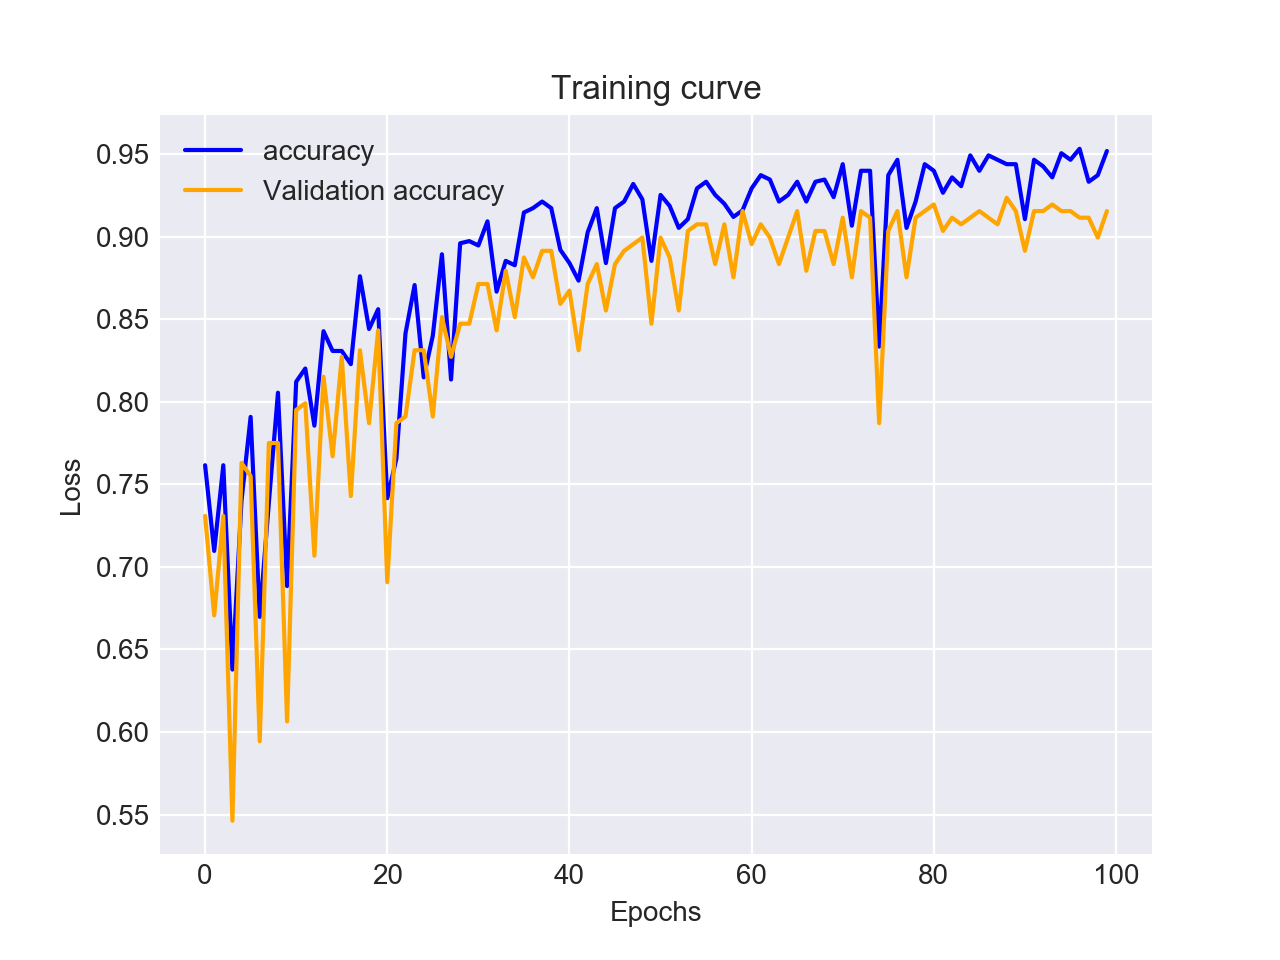

Text(0.5, 1.0, 'Training curve')

In [29]:
%matplotlib notebook
plt.plot(history['acc'] , color = "blue" , label = "accuracy")
plt.plot(history['val_acc'] , color = 'orange' , label = "Validation accuracy")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training curve")

In [23]:
model = CNN()
model.load_state_dict(torch.load("models/CNN_1"))
model.eval()

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2304, out_features=1, bias=True)
)

In [44]:
X = torch.Tensor(val_data_x)
Y = torch.LongTensor(val_data_y)
    
Y_pred = (model(X).detach().numpy().flatten() > 0.5) * 1
Y_real = np.array(Y)
cm = confusion_matrix(Y_real , Y_pred)

/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Confusion matrix, without normalization
[[104   5]
 [ 16 124]]


<IPython.core.display.Javascript object>


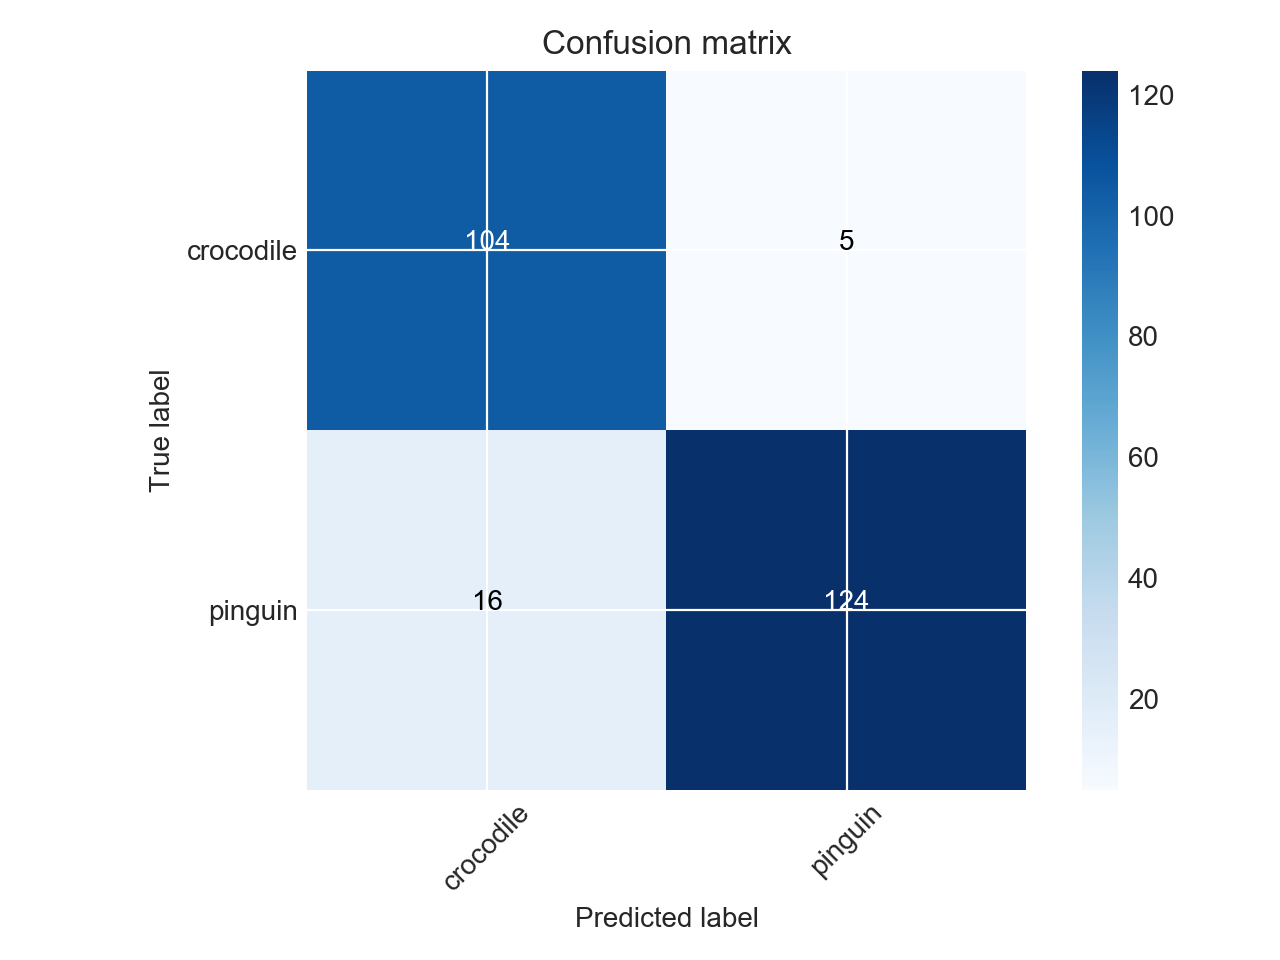

In [48]:
plot_confusion_matrix(cm , ['crocodile','pinguin'])

### Test on google examples

In [32]:
img_croc = Image.open("/Users/charleslaroche/Downloads/1309518-Crocodile.jpg")
n,p = img_croc.size
height = min(n,p)
box = ( 0 , 0 , height , height)
img_croc = img_croc.crop(box)
n,p = img_croc.size
height = min(n,p)
box = ( 0 , 0 , height , height)
img_croc = img_croc.crop(box)
img_croc = img_croc.resize((64,64))
image_test_crocodile = np.array(np.array(img_croc)/255)

<IPython.core.display.Javascript object>


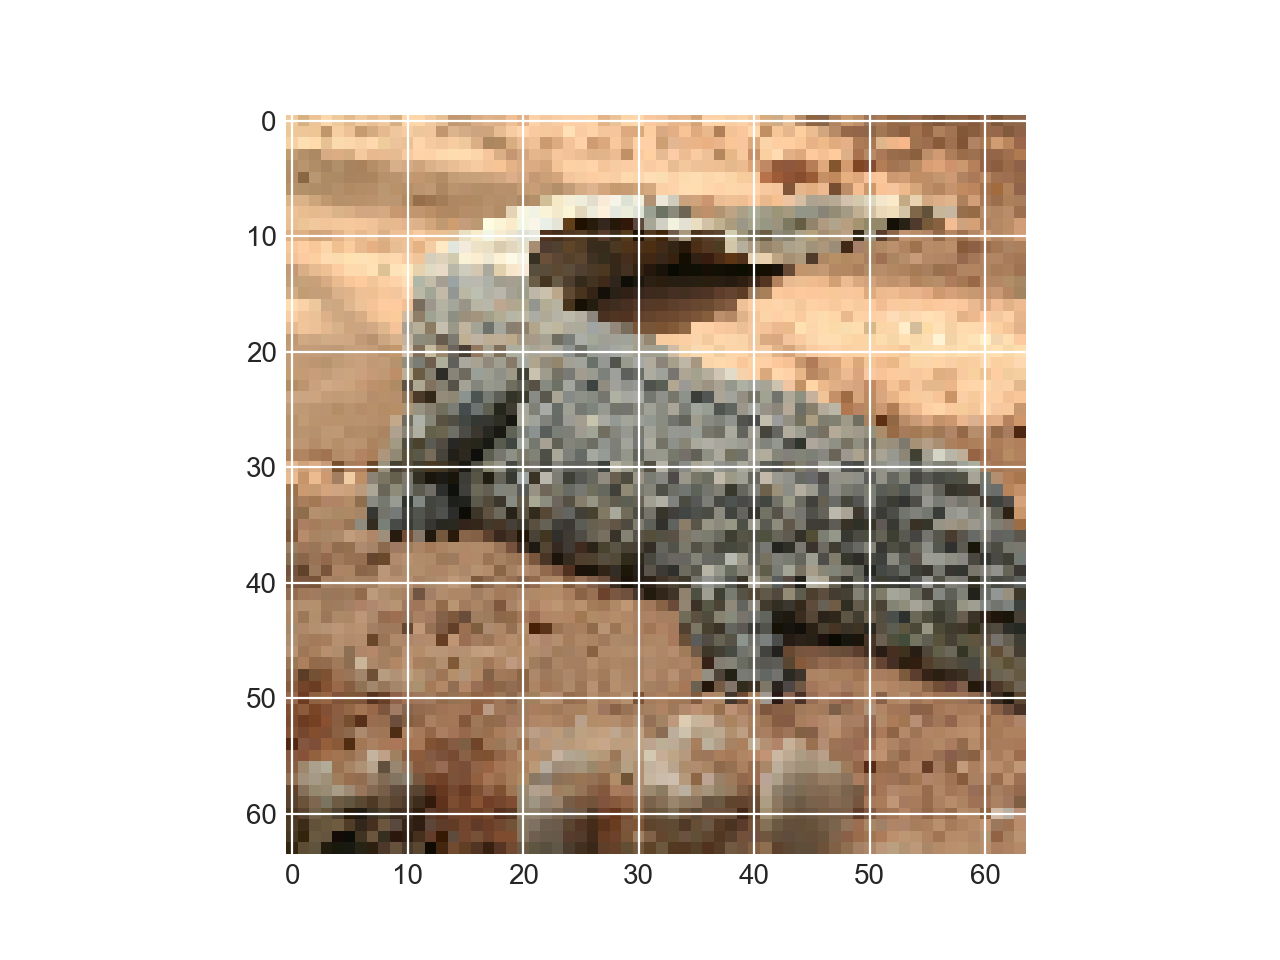

/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


tensor([[0.0238]], grad_fn=<SigmoidBackward>)

In [38]:
plt.imshow(image_test_crocodile)
CNN_(transformer(image_test_crocodile).unsqueeze(0).float())

In [39]:
img_ping = Image.open("/Users/charleslaroche/Downloads/Emperor-cold_hg.jpg")
n,p = img_ping.size
height = min(n,p)
box = ( 0 , 0 , height , height)
img_ping = img_ping.crop(box)
n,p = img_ping.size
height = min(n,p)
box = ( 0 , 0 , height , height)
img_ping = img_ping.crop(box)
img_ping = img_ping.resize((64,64))
image_test_pinguin = np.array(np.array(img_ping)/255)

<IPython.core.display.Javascript object>


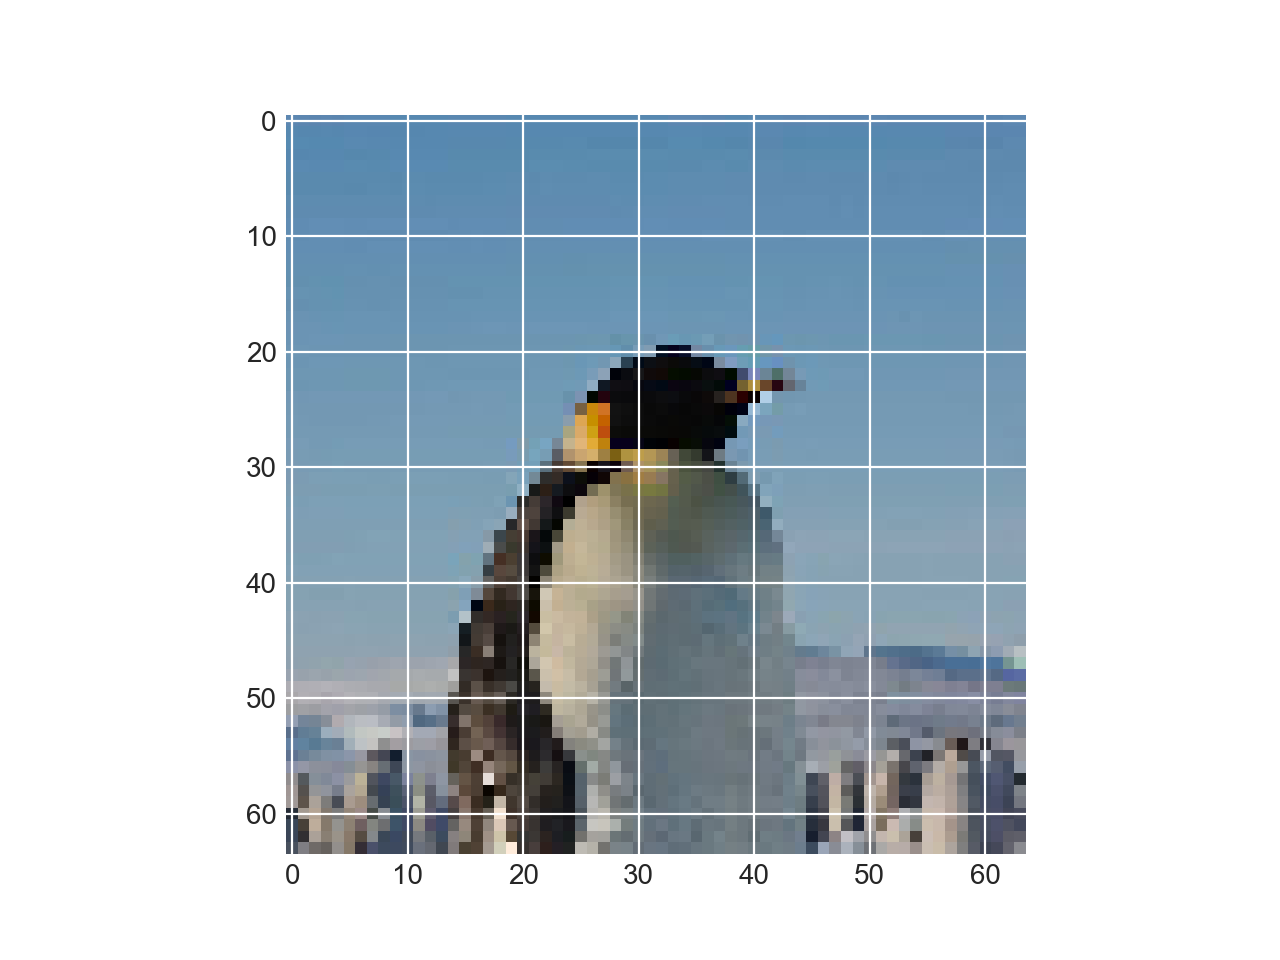

/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


tensor([[0.9959]], grad_fn=<SigmoidBackward>)

In [40]:
plt.imshow(image_test_pinguin)
CNN_(transformer(image_test_pinguin).unsqueeze(0).float())